Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime

In [3]:
AOI_NAME = 'Norfolk' #'Los Angeles' # 'Hawaii'
WEATHER_MODEL = 'GMAO'

In [4]:
if WEATHER_MODEL == 'HRRR':
    assert 'Los-Angeles' in AOI_NAME

In [5]:
GEO_DICT = {'Los-Angeles-0':  Point(-118, 34).buffer(1),
            'Los-Angeles-1':  Point(-118, 34).buffer(1),
            'Hawaii-0': Point(-155.5, 19.5).buffer(1),
            'Hawaii-1': Point(-155.5, 19.5).buffer(1),
            'Norfolk': Point(-76.5, 36.4).buffer(1),
            'Somalia': Point(41, 1.5).buffer(1),
            'Tibet': Point(92, 41.5).buffer(1),
            'Norway': Point(13, 65).buffer(1),
            'Aleutian': Point(-177, 52).buffer(.25),
            }

TRACK_DICT = {'Los-Angeles-0': [64],
              'Los-Angeles-1': [71],
              'Hawaii-0': [124],
              'Hawaii-1': [87],
              'Norfolk': [4],
              'Somalia': [87],
              'Tibet': [48],
              'Norway': [37],
              'Aleutian': [59],
              }

In [6]:
aoi_geo = GEO_DICT[AOI_NAME]
track_numbers = TRACK_DICT[AOI_NAME]

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [7]:
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)

In [8]:
# There will be lots of ways to do this more efficiently i.e. only include frames with overlap of a land mask
# Even to be more confident would likely want some percentage
# Currently, we just shrunk our AOI and excluded a frame
if AOI_NAME == 'Aleutian':
    frames = list(filter(lambda f: f.frame_id!= 9101, frames))

In [9]:
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,492,None,4,4,"POLYGON Z ((-77.82534 34.47332 0.00000, -78.06..."
1,493,None,4,4,"POLYGON Z ((-78.09591 35.63539 0.00000, -78.33..."
2,494,None,4,4,"POLYGON Z ((-78.37797 36.81111 0.00000, -78.41..."


<Axes: >

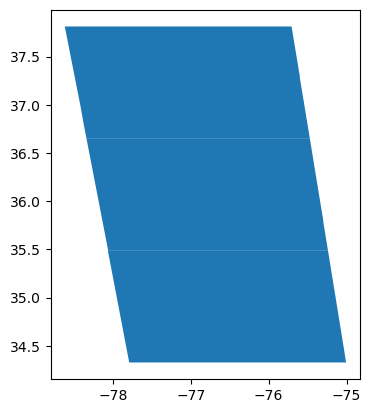

In [10]:
df_frames_all.plot()

(33.325749911225884, 38.81283288963675)

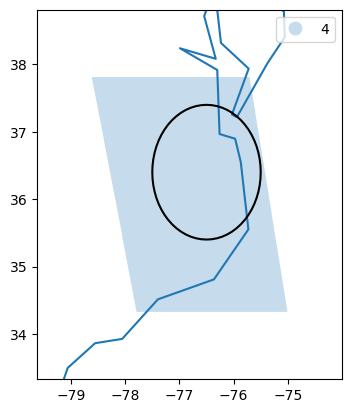

In [11]:
fig, ax = plt.subplots()
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

(33.325749911225884, 38.81283288963675)

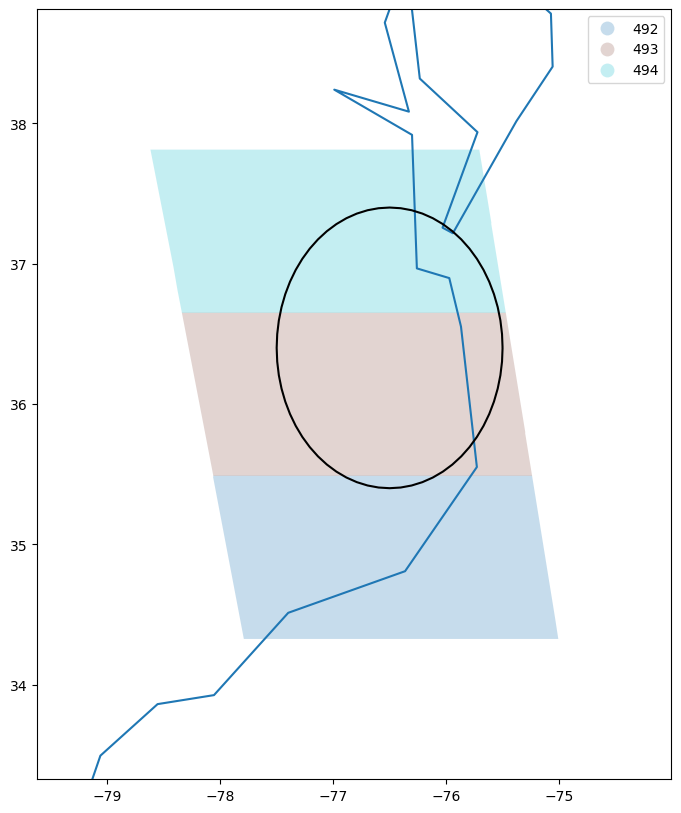

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                   column='frame_id', 
                   alpha=.25,
                   categorical=True,
                   legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')

xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per pass coverage $\geq 80$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [13]:
df_stack = get_s1_stack(frames)
df_stack.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20150310T230524_20150310T2305...,2015-03-10 23:05:24+00:00,2015-03-10 23:05:53+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,4976,IW,4.698847,0,2015-03-10 00:00:00+00:00,"POLYGON ((-78.16130 35.91949, -77.73726 34.123..."
1,S1A_IW_SLC__1SDV_20150310T230551_20150310T2306...,2015-03-10 23:05:51+00:00,2015-03-10 23:06:19+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,4976,IW,4.773019,0,2015-03-10 00:00:00+00:00,"POLYGON ((-78.53279 37.46199, -78.12806 35.783..."
2,S1A_IW_SLC__1SDV_20150310T230617_20150310T2306...,2015-03-10 23:06:17+00:00,2015-03-10 23:06:44+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,4976,IW,4.723698,0,2015-03-10 00:00:00+00:00,"POLYGON ((-78.89915 38.95433, -78.49970 37.333..."
3,S1A_IW_SLC__1SDV_20150825T230531_20150825T2306...,2015-08-25 23:05:31+00:00,2015-08-25 23:06:01+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,7426,IW,4.676370,1,2015-08-25 00:00:00+00:00,"POLYGON ((-78.16091 35.91830, -77.73697 34.122..."
4,S1A_IW_SLC__1SDV_20150825T230559_20150825T2306...,2015-08-25 23:05:59+00:00,2015-08-25 23:06:26+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,7426,IW,4.581264,1,2015-08-25 00:00:00+00:00,"POLYGON ((-78.52041 37.41198, -78.12771 35.783..."


# Select N Dates from stack

To make sure there is weather model availability, we are going to truncate the stack to dates on or before `2022-03-01`.

In [14]:
if AOI_NAME == 'Tibet':
    N = 5
else:
    N = 3

# Give ourselves 1 year buffer
MAX_DATE = pd.Timestamp('2022-03-01', tz='UTC')
df_stack_f = df_stack[df_stack.repeat_pass_timestamp <= MAX_DATE]

dates = sorted(df_stack_f.repeat_pass_timestamp.unique(), reverse=True)
df_stack_f = df_stack_f[df_stack_f.repeat_pass_timestamp >= dates[N]].reset_index(drop=True)
df_stack_f.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20220120T230542_20220120T2306...,2022-01-20 23:05:42+00:00,2022-01-20 23:06:09+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,41551,IW,3.521298,169,2022-01-20 00:00:00+00:00,"POLYGON ((-77.79797 34.25223, -77.41985 32.622..."
1,S1A_IW_SLC__1SDV_20220120T230607_20220120T2306...,2022-01-20 23:06:07+00:00,2022-01-20 23:06:35+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,41551,IW,4.154562,169,2022-01-20 00:00:00+00:00,"POLYGON ((-78.16322 35.79635, -77.76650 34.117..."
2,S1A_IW_SLC__1SDV_20220120T230632_20220120T2306...,2022-01-20 23:06:32+00:00,2022-01-20 23:06:59+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,41551,IW,4.352095,169,2022-01-20 00:00:00+00:00,"POLYGON ((-78.52363 37.28969, -78.13271 35.668..."
3,S1A_IW_SLC__1SDV_20220120T230657_20220120T2307...,2022-01-20 23:06:57+00:00,2022-01-20 23:07:24+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,41551,IW,4.416598,169,2022-01-20 00:00:00+00:00,"POLYGON ((-78.89160 38.78209, -78.49246 37.162..."
4,S1A_IW_SLC__1SDV_20220201T230541_20220201T2306...,2022-02-01 23:05:41+00:00,2022-02-01 23:06:08+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,4,VV+VH,41726,IW,3.685704,170,2022-02-01 00:00:00+00:00,"POLYGON ((-77.79759 34.25279, -77.41953 32.623..."


# Generate Pairs

In [15]:
min_temporal_baseline = 0
neighbors = 2

data = enumerate_gunw_time_series(df_stack_f, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames 
                                 )

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.76it/s]


In [16]:
len(data)

15

In [17]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20220225T230541_20220225T230608_042076_050335_D763',
  'S1A_IW_SLC__1SDV_20220225T230606_20220225T230634_042076_050335_CE69'],
 'secondary': ['S1A_IW_SLC__1SDV_20220213T230541_20220213T230608_041901_04FD2B_FE0C',
  'S1A_IW_SLC__1SDV_20220213T230606_20220213T230634_041901_04FD2B_1CEA'],
 'reference_date': Timestamp('2022-02-25 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2022-02-13 00:00:00+0000', tz='UTC'),
 'frame_id': 492,
 'geometry': <POLYGON Z ((-77.825 34.473 0, -78.064 35.483 0, -78.06 35.484 0, -78.061 35...>}

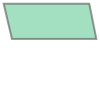

In [18]:
data[0]['geometry']

# Hyp3

In [19]:
TRACKS = ",".join([str(t) for t in TRACK_DICT[AOI_NAME]])
TODAY = datetime.datetime.now().date().strftime('%m%d')
AOI_TOKEN = AOI_NAME.replace(' ', '-')
JOB_NAME = '_'.join([AOI_TOKEN, TRACKS, WEATHER_MODEL, TODAY])
f'JOB_NAME: {JOB_NAME}'

'JOB_NAME: Norfolk_4_GMAO_0323'

In [20]:
f'JOB_NAME character length: {len(JOB_NAME)}'

'JOB_NAME character length: 19'

In [21]:
assert len(JOB_NAME) <= 30

In [22]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                    'weather_model': WEATHER_MODEL,
                    'estimate_ionosphere_delay': True,
                    'compute_solid_earth_tide': True,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20220225T230541_20220225T230608_042076_050335_D763',
   'S1A_IW_SLC__1SDV_20220225T230606_20220225T230634_042076_050335_CE69'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20220213T230541_20220213T230608_041901_04FD2B_FE0C',
   'S1A_IW_SLC__1SDV_20220213T230606_20220213T230634_041901_04FD2B_1CEA'],
  'weather_model': 'GMAO',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 492},
 {'granules': ['S1A_IW_SLC__1SDV_20220225T230606_20220225T230634_042076_050335_CE69',
   'S1A_IW_SLC__1SDV_20220225T230632_20220225T230659_042076_050335_3D61'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20220213T230606_20220213T230634_041901_04FD2B_1CEA',
   'S1A_IW_SLC__1SDV_20220213T230632_20220213T230659_041901_04FD2B_8DB4'],
  'weather_model': 'GMAO',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 493}]

In [23]:
job_dicts = [{'name': JOB_NAME,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': parameters
             }
             for parameters in job_parameters]
job_dicts[:2]

[{'name': 'Norfolk_4_GMAO_0323',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20220225T230541_20220225T230608_042076_050335_D763',
    'S1A_IW_SLC__1SDV_20220225T230606_20220225T230634_042076_050335_CE69'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20220213T230541_20220213T230608_041901_04FD2B_FE0C',
    'S1A_IW_SLC__1SDV_20220213T230606_20220213T230634_041901_04FD2B_1CEA'],
   'weather_model': 'GMAO',
   'estimate_ionosphere_delay': True,
   'compute_solid_earth_tide': True,
   'frame_id': 492}},
 {'name': 'Norfolk_4_GMAO_0323',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20220225T230606_20220225T230634_042076_050335_CE69',
    'S1A_IW_SLC__1SDV_20220225T230632_20220225T230659_042076_050335_3D61'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20220213T230606_20220213T230634_041901_04FD2B_1CEA',
    'S1A_IW_SLC__1SDV_20220213T230632_20220213T230659_041901_04FD2B_8DB4'],
   'weather_model': 'GMAO',
   'est

In [24]:
len(job_dicts)

15

You may want to use `prompt=True` to toggle between Earthdata accounts.

In [25]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')

Uncomment this to submit jobs:

In [26]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:])

These are useful snippets to inspect status and view metadata.

In [27]:
jobs = hyp3_isce.find_jobs(name=JOB_NAME)
print(jobs)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.


In [28]:
# jobs[0].to_dict()

In [29]:
# successful_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='SUCCEEDED')
# dicts_success = [j.to_dict() for j in successful_jobs]
# dicts_success[:]

In [30]:
# urls = [d['files'][0]['url'] for d in dicts_success]
# urls

In [31]:
# all_jobs = hyp3_isce.find_jobs(name=JOB_NAME)
# dicts_all = [j.to_dict() for j in all_jobs]
# dicts_all[:]

# Failed Jobs and Resubmission

In [32]:
failed_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='FAILED')
dicts_failed = [j.to_dict() for j in failed_jobs]
dicts_failed[:]

[]

In [33]:
JOB_NAME_RESUBMIT = JOB_NAME + '_v2'

In [34]:
job_dicts_resubmit = [{'name': JOB_NAME_RESUBMIT,
                       # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
                       'job_type': 'INSAR_ISCE_TEST',
                      'job_parameters': d['job_parameters']
                      }
                     for d in dicts_failed[:1]]
job_dicts_resubmit

[]

In [35]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts_resubmit[:])

In [36]:
jobs_v2 = hyp3_isce.find_jobs(name=JOB_NAME_RESUBMIT)
print(jobs_v2)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.
